# MODELING - CLASSIFICATION

This notebook focuses on developing models to predict stockout events before they occur. 

Using the balanced dataset derived from historical retail operations, we train and evaluate several classification algorithms to identify which products are at the highest risk of going out of stock.

By prioritizing recall, the goal is to minimize missed stockout events, ensuring better product availability and operational decision-making.

If there's any issue with memory or computation during this process, they can be reduced by:

* Sampling
* Undersampling balancing
* Reduce the number of algorithms to test
* Reduce the number of parameters to test
* Use Random Search and specify an adequate n_iter

## IMPORT DATA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    recall_score,
    precision_score,
    average_precision_score,
    PrecisionRecallDisplay,
    f1_score,
    RocCurveDisplay
)

import scikitplot as skplt

%config IPCompleter.greedy=True                    # Faster autocomplete
pd.options.display.float_format = '{:.2f}'.format   # Disable scientific notation

import warnings                                     # Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
project_path = '/Users/rober/retail-stockout-risk-scoring/'

name_X = 'X_balanced.pickle'
name_y = 'y_balanced.pickle'

X = pd.read_pickle(project_path + '/02_Data/03_Working/' + name_X)
y = pd.read_pickle(project_path + '/02_Data/03_Working/' + name_y)

In [6]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Stockout distribution:")
print(y.value_counts(normalize=True))

X shape: (37690, 18)
y shape: (37690,)
Stockout distribution:
stockout_14d
1   0.50
0   0.50
Name: proportion, dtype: float64


## MODELING

### Split Dataset Into Training and Validation Sets

In [7]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Stratified split to maintain balanced classes

print("Train size:", train_X.shape, train_y.shape)
print("Validation size:", val_X.shape, val_y.shape)

Train size: (26383, 18) (26383,)
Validation size: (11307, 18) (11307,)


### Create Model Pipeline and Parameter Search Space

This grid tests four candidate algorithms:

- Logistic Regression
- Random Forest
- XGBoost
- HistGradientBoosting

In [8]:
pipe = Pipeline([
    ('model', RandomForestClassifier())  # placeholder — GridSearch will swap algorithm
])

param_grid = [
    {
        'model': [LogisticRegression(max_iter=2000)],
        'model__solver': ['saga'],
        'model__penalty': ['elasticnet', 'l1', 'l2', 'none'],
        'model__C': [0.0, 0.25, 0.5, 0.75, 1],
        'model__n_jobs': [-1]
    },
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [5, 10, 15],
        'model__n_jobs': [-1]
    },
    {
        'model': [XGBClassifier()],
        'model__verbosity': [0],
        'model__learning_rate': [0.01, 0.025, 0.05, 0.1],
        'model__max_depth': [5, 10, 20],
        'model__reg_alpha': [0.0, 0.1, 0.5, 1],
        'model__reg_lambda': [0.01, 0.1, 1],
        'model__n_estimators': [100, 500, 1000],
        'model__n_jobs': [-1]
    },
    {
        'model': [HistGradientBoostingClassifier()],
        'model__learning_rate': [0.01, 0.025, 0.05, 0.1],
        'model__max_iter': [50, 100, 200],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_leaf': [500],
        'model__l2_regularization': [0.0, 0.25, 0.5, 0.75, 1]
    }
]

### Optimize Hyperparameters

To speed up experimentation, we will use **Random Search** first.

Scoring Metric: **Recall**, because missing a stockout is more costly than a false alarm.

####  Grid Search

In [9]:
# grid_search = GridSearchCV(estimator= pipe, 
#                            param_grid = grid, 
#                            cv = 3, 
#                            scoring = 'roc_auc',
#                            verbose = 0,
#                            n_jobs = -1)

# modelo = grid_search.fit(train_x,train_y)

# pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

####  Random Search

In [10]:
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=10,         # testing more parameter sets than original template (better results)
    scoring='recall',  # prioritize stockout detection
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(train_X, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression(max_iter=2000)],
                                         'model__C': [0.0, 0.25, 0.5, 0.75, 1],
                                         'model__n_jobs': [-1],
                                         'model__penalty': ['elasticnet', 'l1',
                                                            'l2', 'none'],
                                         'model__solver': ['saga']},
                                        {'model': [RandomForestClassifier()],
                                         'model__max_depth': [5,...
                                         'model__reg_alpha': [0.0, 0.1, 0.5, 1],
                                         'model__reg_lambda': [0.01, 0.1, 1],
                                         'model__verbosity': [0]},
                                        {'model': [HistGradientBoostingClassifier()],
                                         'model__l2_regularization': [0.0, 0.25,
                                                                      0.5, 0.75,
                                                                      1],
                                         'model__learning_rate': [0.01, 0.025,
                                                                  0.05, 0.1],
                                         'model__max_depth': [5, 10, 20],
                                         'model__max_iter': [50, 100, 200],
                                         'model__min_samples_leaf': [500]}],
                   random_state=42, scoring='recall', verbose=1)

In [22]:
random_search.best_estimator_

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [12]:
results_df = pd.DataFrame(random_search.cv_results_) \
                 .sort_values(by='rank_test_score')

pd.set_option('display.max_columns', None)  # show all hyperparams
display(results_df.head(10))  

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbosity,param_model__reg_lambda,param_model__reg_alpha,param_model__n_jobs,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__min_samples_leaf,param_model__max_iter,param_model__l2_regularization,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,89.79,9.62,0.70,0.22,0,1,1,-1,500,10,0.05,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 1...",0.97,0.98,0.97,0.97,0.00,1
3,165.83,22.14,2.50,1.32,0,0.10,0.50,-1,1000,10,0.05,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.97,0.97,0.97,0.97,0.00,2
8,208.41,4.30,1.21,0.11,0,1,1,-1,1000,20,0.03,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 1...",0.97,0.97,0.97,0.97,0.00,3
5,133.95,2.74,0.73,0.12,0,0.10,0.50,-1,500,20,0.05,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.97,0.97,0.97,0.97,0.00,4
9,72.10,22.01,0.45,0.16,0,0.01,0.00,-1,500,20,0.10,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.97,0.97,0.97,0.97,0.00,5
2,23.50,1.56,0.13,0.03,0,0.01,1,-1,100,20,0.10,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.97,0.97,0.97,0.97,0.00,6
0,102.78,1.73,1.04,0.25,0,0.01,1,-1,500,10,0.01,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.96,0.96,0.96,0.96,0.00,7
4,25.25,7.91,0.11,0.03,0,0.10,0.50,-1,100,10,0.01,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,"{'model__verbosity': 0, 'model__reg_lambda': 0...",0.95,0.95,0.94,0.95,0.00,8
7,1.67,0.36,0.23,0.09,NaN,NaN,NaN,NaN,NaN,20,0.05,HistGradientBoostingClassifier(),500,100,0.50,"{'model__min_samples_leaf': 500, 'model__max_i...",0.94,0.94,0.94,0.94,0.00,9
6,2.65,1.31,0.21,0.05,NaN,NaN,NaN,NaN,NaN,5,0.03,HistGradientBoostingClassifier(),500,50,0.25,"{'model__min_samples_leaf': 500, 'model__max_i...",0.92,0.93,0.93,0.93,0.00,10


## EVALUATE

### Confusion Matrix & Metrics Report

(focused on Recall for stockout prediction)

We will evaluate the best model on the validation set and visualize results clearly.

#### Predict over validation

In [13]:
pred = random_search.best_estimator_.predict_proba(val_X)[:, 1]

#### Evaluate over validation

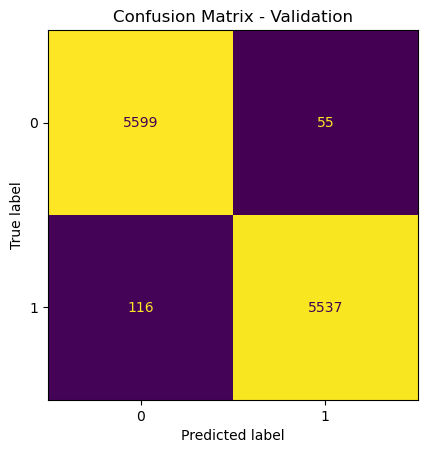

Classification Metrics (Validation Set)
              precision    recall  f1-score   support

           0      0.980     0.990     0.985      5654
           1      0.990     0.979     0.985      5653

    accuracy                          0.985     11307
   macro avg      0.985     0.985     0.985     11307
weighted avg      0.985     0.985     0.985     11307

Key Business Metric: Recall (Stockout Detection)
Recall: 0.979


In [14]:
# Convert predicted probabilities into class predictions
pred_class = (pred >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(val_y, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False)
plt.title("Confusion Matrix - Validation")
plt.show()

# Classification Report
print("Classification Metrics (Validation Set)")
print(classification_report(val_y, pred_class, digits=3))

print("Key Business Metric: Recall (Stockout Detection)")
print("Recall:", recall_score(val_y, pred_class).round(3))

## EXTRACT THE BEST MODEL

In [15]:
random_search.best_estimator_

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## REPORTING

These charts are primarily for reporting and **business explainability**, not directly for the deployment phase.

They help stakeholders understand:

- how reliable the model is
- what value it adds
- how well it detects real stockouts
- how it prioritizes operational effort

### Precision–Recall Curve

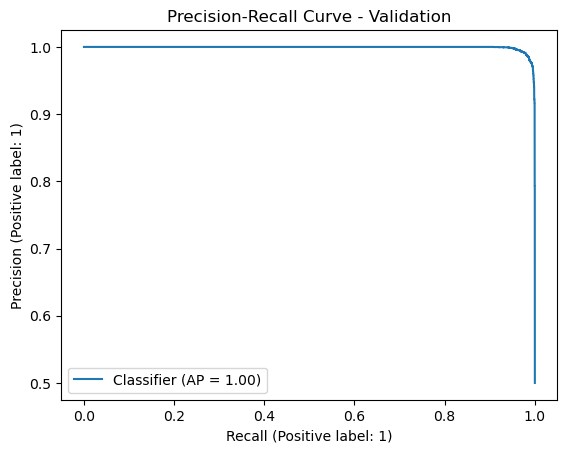

PR-AUC: 0.9992155321527


In [16]:
PrecisionRecallDisplay.from_predictions(val_y, pred)
plt.title("Precision-Recall Curve - Validation")
plt.show()

pr_auc = average_precision_score(val_y, pred)
print("PR-AUC:", pr_auc)

**This sis our #1 business-critical curve for stockout detection**

When the model predicts a stockout, does it detect most of the real ones (Recall) while avoiding too many false alarms (Precision)?

PR-AUC  = How well we detect and trust positives (stockouts)


### Cumulative Gain Chart

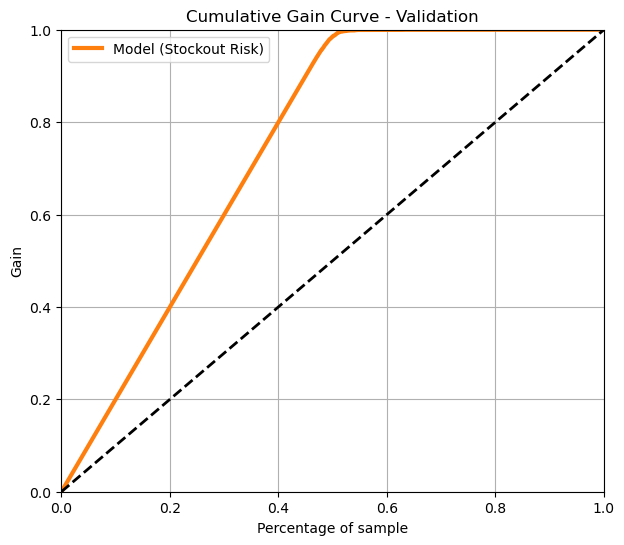

In [17]:
fig, ax = plt.subplots(figsize=(7,6))

skplt.metrics.plot_cumulative_gain(
    val_y,
    random_search.best_estimator_.predict_proba(val_X),
    ax=ax
)

# Remove the Class 0 line (not relevant for business)
lines = ax.get_lines()
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

# Legend
plt.legend(labels=['Model (Stockout Risk)'])

plt.title("Cumulative Gain Curve - Validation")
plt.show()

The Cumulative Gain Curve shows how much the model allows us to reduce the number of products that need operational attention while still capturing most future stockouts.

This one looks like a well-performing risk model should look

- At 30% of SKUs reviewed, the model captures ~90% of stockouts
- At 50% of SKUs reviewed, the model captures ~100% of stockouts

_(*) SKU = Stock Keeping Unit = unique identifier for a specific product variant in inventory = we can say just "Product" as they are Product IDs_

Model curve is far above the “random” dashed line

The model prioritizes stockouts extremely well allowing operations to focus effort only where needed

Strategic insight:

**We can eliminate the majority of stockouts by proactively monitoring only the riskiest 30% of products, saving labor and avoiding lost revenue.** 

#### Which products should we monitor?

It will be available on the final Streamlit web application we'll build at the end of this project. 

This interface will automatically score all active products daily and prioritize the top 30% or top 50% highest-risk items for proactive replenishment.

Users will be able to download the prioritized product list and explore risk drivers interactively, making the solution actionable for operations.

#### Same Gain Chart with annotations

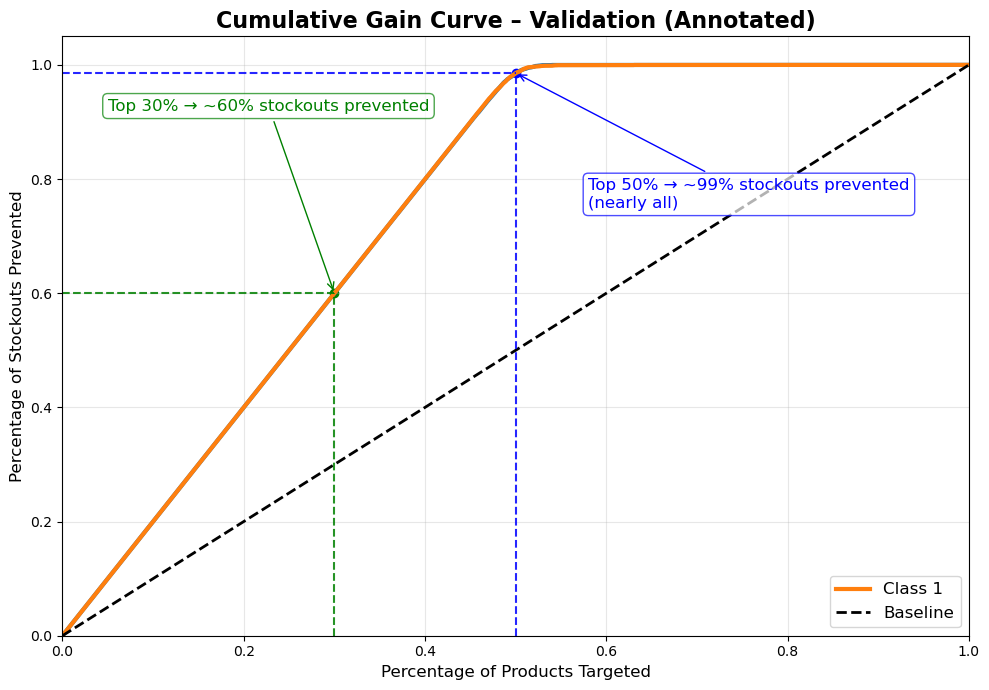

In [18]:
y_proba = random_search.best_estimator_.predict_proba(val_X)

fig, ax = plt.subplots(figsize=(10,7))

skplt.metrics.plot_cumulative_gain(val_y, y_proba, ax=ax)

# Ensure correct legend labels are kept
# Remove "Class 0" only
new_lines = []
new_labels = []
for line, label in zip(ax.get_lines(), [l.get_label() for l in ax.get_lines()]):
    if label != 'Class 0':
        new_lines.append(line)
        new_labels.append(label)
ax.legend(new_lines, new_labels, fontsize=12, loc='lower right')

# Extract Model curve data
curve = new_lines[0]  # model curve
xs = curve.get_xdata()
ys = curve.get_ydata()

def get_y_value(x_target):
    return ys[(np.abs(xs - x_target)).argmin()]

# Points
top30, top50 = 0.30, 0.50
gain30, gain50 = get_y_value(top30), get_y_value(top50)


# Axis-linked dashed guides

## Top 30%
ax.plot([top30, top30], [0, gain30], 'g--', alpha=0.85)
ax.plot([0, top30], [gain30, gain30], 'g--', alpha=0.85)
ax.scatter([top30], [gain30], color='green')

ax.annotate(f"Top 30% → ~{gain30:.0%} stockouts prevented",
            xy=(top30, gain30),
            xytext=(0.05, 0.92),
            arrowprops=dict(arrowstyle="->", color="green"),
            fontsize=12, color="green",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.7)
)

## Top 50%
ax.plot([top50, top50], [0, gain50], 'b--', alpha=0.85)
ax.plot([0, top50], [gain50, gain50], 'b--', alpha=0.85)
ax.scatter([top50], [gain50], color='blue')

ax.annotate(f"Top 50% → ~{gain50:.0%} stockouts prevented\n(nearly all)",
            xy=(top50, gain50),
            xytext=(0.58, 0.75),
            arrowprops=dict(arrowstyle="->", color="blue"),
            fontsize=12, color="blue",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.7)
)

# Styling
ax.set_title("Cumulative Gain Curve – Validation (Annotated)",
             fontsize=16, weight='bold')
ax.set_xlabel("Percentage of Products Targeted", fontsize=12)
ax.set_ylabel("Percentage of Stockouts Prevented", fontsize=12)
ax.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


### Lift Curve

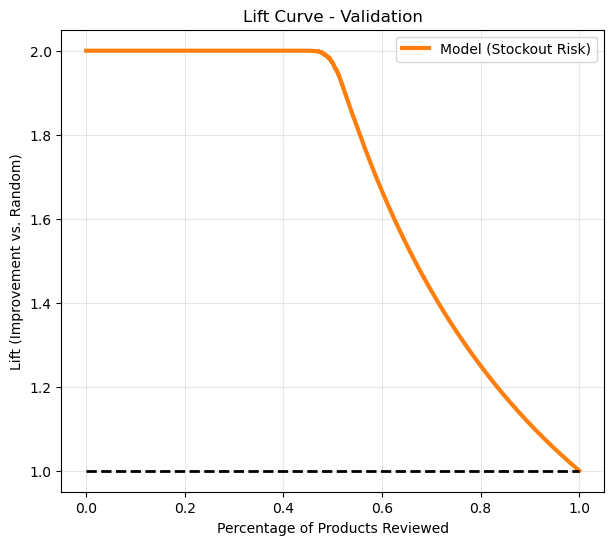

In [19]:
fig, ax = plt.subplots(figsize=(7,6))

skplt.metrics.plot_lift_curve(
    val_y,
    random_search.best_estimator_.predict_proba(val_X),
    ax=ax
)

# Remove Class 0 line
lines = ax.get_lines()
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

# Custom legend
plt.legend(labels=['Model (Stockout Risk)'])

plt.title("Lift Curve - Validation")
plt.xlabel("Percentage of Products Reviewed")
plt.ylabel("Lift (Improvement vs. Random)")
plt.grid(alpha=0.3)
plt.show()

Lift Chart shows how much better the model performs compared to choosing products at random.
- The orange curve represents our model
- The dashed black line represents a random strategy baseline (Lift = 1)

At 30% of products: The model is ~2× more effective than random
→ We detect twice as many stockouts with the same effort

Up to 50% of products: Lift remains above 1.5×, still highly valuable

Beyond 50%: Lift quickly drops toward 1×
→ No additional benefit from reviewing more products


Business Insight:
We should focus on the riskiest Top 30% of products to capture most stockouts with the highest operational efficiency.

If more resources become available, we can extend to Top 50%, but returns diminish beyond that point.

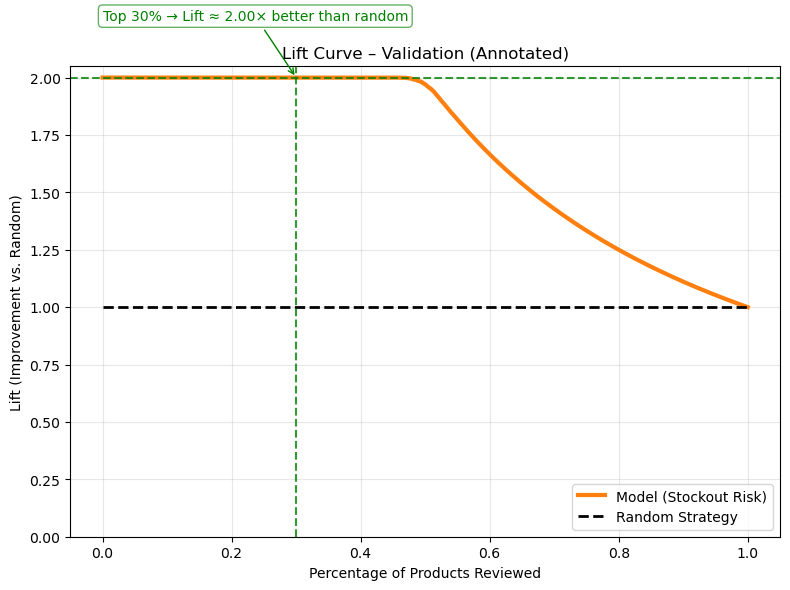

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

skplt.metrics.plot_lift_curve(
    val_y,
    random_search.best_estimator_.predict_proba(val_X),
    ax=ax
)

# Remove the Class 0 curve (not useful for business)
lines = ax.get_lines()
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

# Identify lift at 30%
top_30 = 0.30
# Find approximate lift value at 30%
curve_line = ax.get_lines()[0]
xs = curve_line.get_xdata()
ys = curve_line.get_ydata()
# Find nearest index to 30%
idx = (np.abs(xs - top_30)).argmin()
lift_at_30 = ys[idx]

# Add vertical and horizontal guides
ax.axvline(top_30, color='green', linestyle='--', alpha=0.8)
ax.axhline(lift_at_30, color='green', linestyle='--', alpha=0.8)

# Add annotation (adjusted position to avoid title overlap)
ax.annotate(f"Top 30% → Lift ≈ {lift_at_30:.2f}× better than random",
            xy=(top_30, lift_at_30),
            xytext=(0.000000000001, lift_at_30 + 0.25),  # moved higher & left
            arrowprops=dict(arrowstyle='->', color='green'),
            color='green', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.6)
           )

# Styling
ax.set_title("Lift Curve – Validation (Annotated)")
ax.set_xlabel("Percentage of Products Reviewed")
ax.set_ylabel("Lift (Improvement vs. Random)")
ax.grid(alpha=0.3)
plt.ylim(0, None)
plt.tight_layout()

# Removing Class 0 from legend
new_lines = []
new_labels = []
for line, label in zip(ax.get_lines(), [l.get_label() for l in ax.get_lines()]):
    if label == "Class 1":
        new_lines.append(line)
        new_labels.append("Model (Stockout Risk)")
    elif label == "Baseline":
        new_lines.append(line)
        new_labels.append("Random Strategy")

ax.legend(new_lines, new_labels, fontsize=10, loc="lower right")

plt.show()

### ROC Curve

Can the model tell risky products apart from safe ones?

ROC-AUC = How well classes are separated (overall)

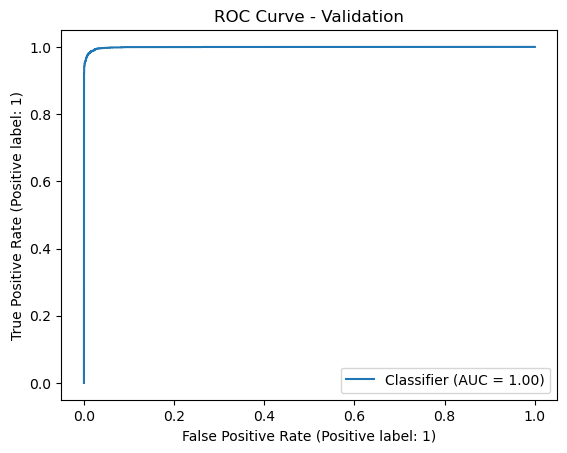

ROC-AUC: 0.9991763672819358


In [21]:
RocCurveDisplay.from_predictions(val_y, pred)
plt.title("ROC Curve - Validation")
plt.show()

roc_auc = roc_auc_score(val_y, pred)
print("ROC-AUC:", roc_auc)